In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Dense, Dropout, LSTM
from tensorflow.keras.models import Sequential
import yfinance as yf
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore

In [ ]:
# Initialize Firebase
cred = credentials.Certificate('/content/drive/MyDrive/Predictions/financiaflutter-firebase-adminsdk-ajaw7-f515e50a59.json')
firebase_admin.initialize_app(cred)

[*********************100%***********************]  1 of 1 completed
Epoch 1/25
57/57 [==============================] - 12s 83ms/step - loss: 0.0213
Epoch 2/25
57/57 [==============================] - 5s 83ms/step - loss: 0.0046
Epoch 3/25
57/57 [==============================] - 7s 115ms/step - loss: 0.0043
Epoch 4/25
57/57 [==============================] - 5s 83ms/step - loss: 0.0039
Epoch 5/25
57/57 [==============================] - 6s 100ms/step - loss: 0.0038
Epoch 6/25
57/57 [==============================] - 6s 98ms/step - loss: 0.0042
Epoch 7/25
57/57 [==============================] - 6s 102ms/step - loss: 0.0040
Epoch 8/25
57/57 [==============================] - 7s 115ms/step - loss: 0.0043
Epoch 9/25
57/57 [==============================] - 5s 83ms/step - loss: 0.0040
Epoch 10/25
57/57 [==============================] - 6s 97ms/step - loss: 0.0035
Epoch 11/25
57/57 [==============================] - 6s 100ms/step - loss: 0.0036
Epoch 12/25
57/57 [========================

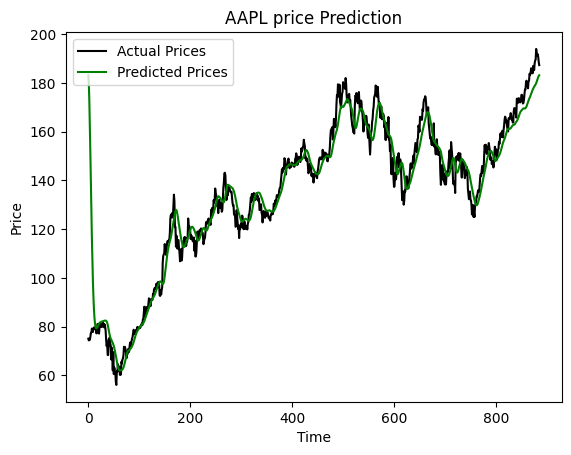

1/1 [==============================] - 1s 1s/step
[[183.207]]


In [ ]:
crypto_currency = 'AAPL'
against_currency = 'USD'

start = dt.datetime(2016,1,1)
end = dt.datetime.now()

data1 = yf.download('AAPL', start=start, end=end)

from sklearn.preprocessing import MinMaxScaler

scalar= MinMaxScaler(feature_range=(0,1))
scaled_data1 =scalar.fit_transform(data1['Close'].values.reshape(-1,1))

prediction_days = 60
future_day = 10

x_train1, y_train1=[], []

for x in range(prediction_days, len(scaled_data1)-future_day):
  x_train1.append(scaled_data1[x-prediction_days:x, 0])
  y_train1.append(scaled_data1[x+future_day, 0])

x_train1, y_train1 = np.array(x_train1), np.array(y_train1)
x_train1 = np.reshape(x_train1, (x_train1.shape[0], x_train1.shape[1], 1))


model1 = Sequential()

model1.add(LSTM(units=50, return_sequences=True, input_shape=(x_train1.shape[1], 1)))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50, return_sequences=True))
model1.add(Dropout(0.2))
model1.add(LSTM(units=50))
model1.add(Dropout(0.2))
model1.add(Dense(units=1))

model1.compile(optimizer='adam', loss='mean_squared_error')
model1.fit(x_train1, y_train1, epochs=25, batch_size=32)


test_start = dt.datetime(2020,1,1)
test_end = dt.datetime.now()

test_data1 = yf.download('AAPL', start=test_start, end=test_end)
actual_prices1 = test_data1['Close'].values

total_dataset1 = pd.concat((data1['Close'], test_data1['Close']), axis=0)

model_inputs1 = total_dataset1[len(total_dataset1) - len(test_data1) - prediction_days:].values
model_inputs1 = model_inputs1.reshape(-1, 1)
model_inputs1 = scalar.fit_transform(model_inputs1)


x_test1 = []

for x in range(prediction_days, len(model_inputs1)):
  x_test1.append(model_inputs1[x-prediction_days:x, 0])

x_test1 = np.array(x_test1)
x_test1 = np.reshape(x_test1, (x_test1.shape[0], x_test1.shape[1], 1))


prediction_prices1 = model1.predict(x_test1)
prediction_prices1 = scalar.inverse_transform(prediction_prices1)


plt.plot(actual_prices1, color='black', label='Actual Prices')
plt.plot(prediction_prices1, color='green', label='Predicted Prices')
plt.title('AAPL price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend(loc = 'upper left')
plt.show()

real_data1 = [model_inputs1[len(model_inputs1)+1 - prediction_days:len(model_inputs1) + 1, 0]]
real_data1 = np.array(real_data1)
real_data1 = np.reshape(real_data1, (real_data1.shape[0],real_data1.shape[1], 1))

prediction1 = model1.predict(real_data1)
prediction1 = scalar.inverse_transform(prediction1)
print(prediction1)

In [ ]:
# Save the prediction value to Firebase Firestore
db = firestore.client()
doc_ref = db.collection('predictionstock').document(crypto_currency)
doc_ref.set({
    'prediction': float(prediction1[0][0])
})

update_time {
  seconds: 1689102096
  nanos: 307573000
}